In [1]:
from dotenv import load_dotenv
print(load_dotenv())

True


In [2]:
!kaggle competitions download -c playground-series-s6e1

playground-series-s6e1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
import os
# 압축 파일 경로 (정방향 슬래시 사용)
zip_file_path = 'C:/Users/subin/github/playground-series-s6e1.zip'
# 압축을 풀 대상 디렉토리
extract_to_path = 'C:/Users/subin/github'
# zip 파일 열기 및 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
    print(f"압축 해제 완료: {extract_to_path}")
# 해제된 파일 목록 확인
print("현재 폴더 파일 목록:", os.listdir(extract_to_path))

압축 해제 완료: C:/Users/subin/github
현재 폴더 파일 목록: ['.env', '.gitignore', 'DSWebApp', 'FirstProject', 'Heosubin', 'Heosubin_Student Score Predict', 'Little-Sonny', 'playground-series-s6e1.zip', 'Practice', 'sample_submission.csv', 'test.csv', 'train.csv', '학생점수예측1.ipynb']


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import joblib

# warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 한글 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [5]:
trainPath = os.path.join(extract_to_path, 'train.csv')
testPath = os.path.join(extract_to_path, 'test.csv')
train_df = pd.read_csv(trainPath)
test_df = pd.read_csv(testPath)
train_df.head(10)
# test_df.head(10)

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0
5,5,24,male,b.com,5.04,85.1,yes,9.4,average,online videos,medium,moderate,70.1
6,6,20,male,b.sc,4.28,87.0,no,9.1,average,mixed,high,moderate,63.4
7,7,22,female,ba,4.19,44.9,yes,8.8,good,self-study,high,hard,76.8
8,8,22,other,b.com,1.06,98.3,yes,5.0,poor,mixed,low,moderate,46.7
9,9,18,male,bba,3.44,80.9,yes,6.2,good,group study,medium,easy,58.2


In [6]:
train_df.columns

Index(['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance',
       'internet_access', 'sleep_hours', 'sleep_quality', 'study_method',
       'facility_rating', 'exam_difficulty', 'exam_score'],
      dtype='object')

In [7]:
train_df.isnull().sum()

id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

## 📊 학생 성적 데이터셋 컬럼 정의

### 1. 학생 기본 정보 (Demographics)

학생 개개인의 배경을 나타내는 기초 정보입니다.

* **id**: 학생 고유 식별 번호 (분석 시에는 제외하거나 인덱스로 사용)
* **age**: 학생의 나이 (수치형)
* **gender**: 성별 (범주형: Male, Female 등)
* **course**: 현재 수강 중인 학위 과정 (범주형: B.Tech, B.Sc, BCA, BA 등)

### 2. 학습 행동 및 환경 (Study Habits & Environment)

학습 태도 및 외부 환경 요인입니다.

* **study_hours**: 일일 혹은 주간 공부 시간 (수치형)
* **class_attendance**: 수업 출석률 (수치형/비율)
* **study_method**: 선호하는 학습 방법 (범주형: Self-study, Group, Online 등)
* **internet_access**: 인터넷 사용 가능 여부 (범주형: Yes, No)
* **facility_rating**: 학교/학습 시설에 대한 만족도 (수치형/범주형: 1~5점 척도 등)

### 3. 생활 습관 및 컨디션 (Lifestyle)

신체적 컨디션과 관련된 간접 영향 요인입니다.

* **sleep_hours**: 평균 수면 시간 (수치형)
* **sleep_quality**: 수면의 질 (범주형: Low, Medium, High 등)

### 4. 시험 관련 결과 (Exam Context & Outcome)

분석의 핵심이 되는 결과 및 상황 정보입니다.

* **exam_difficulty**: 해당 시험의 난이도 (범주형: Easy, Medium, Hard)
* **exam_score**: **[목표 변수]** 최종 시험 점수 (수치형)


In [8]:
train_df['course'].unique()

array(['b.sc', 'diploma', 'bca', 'b.com', 'ba', 'bba', 'b.tech'],
      dtype=object)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB


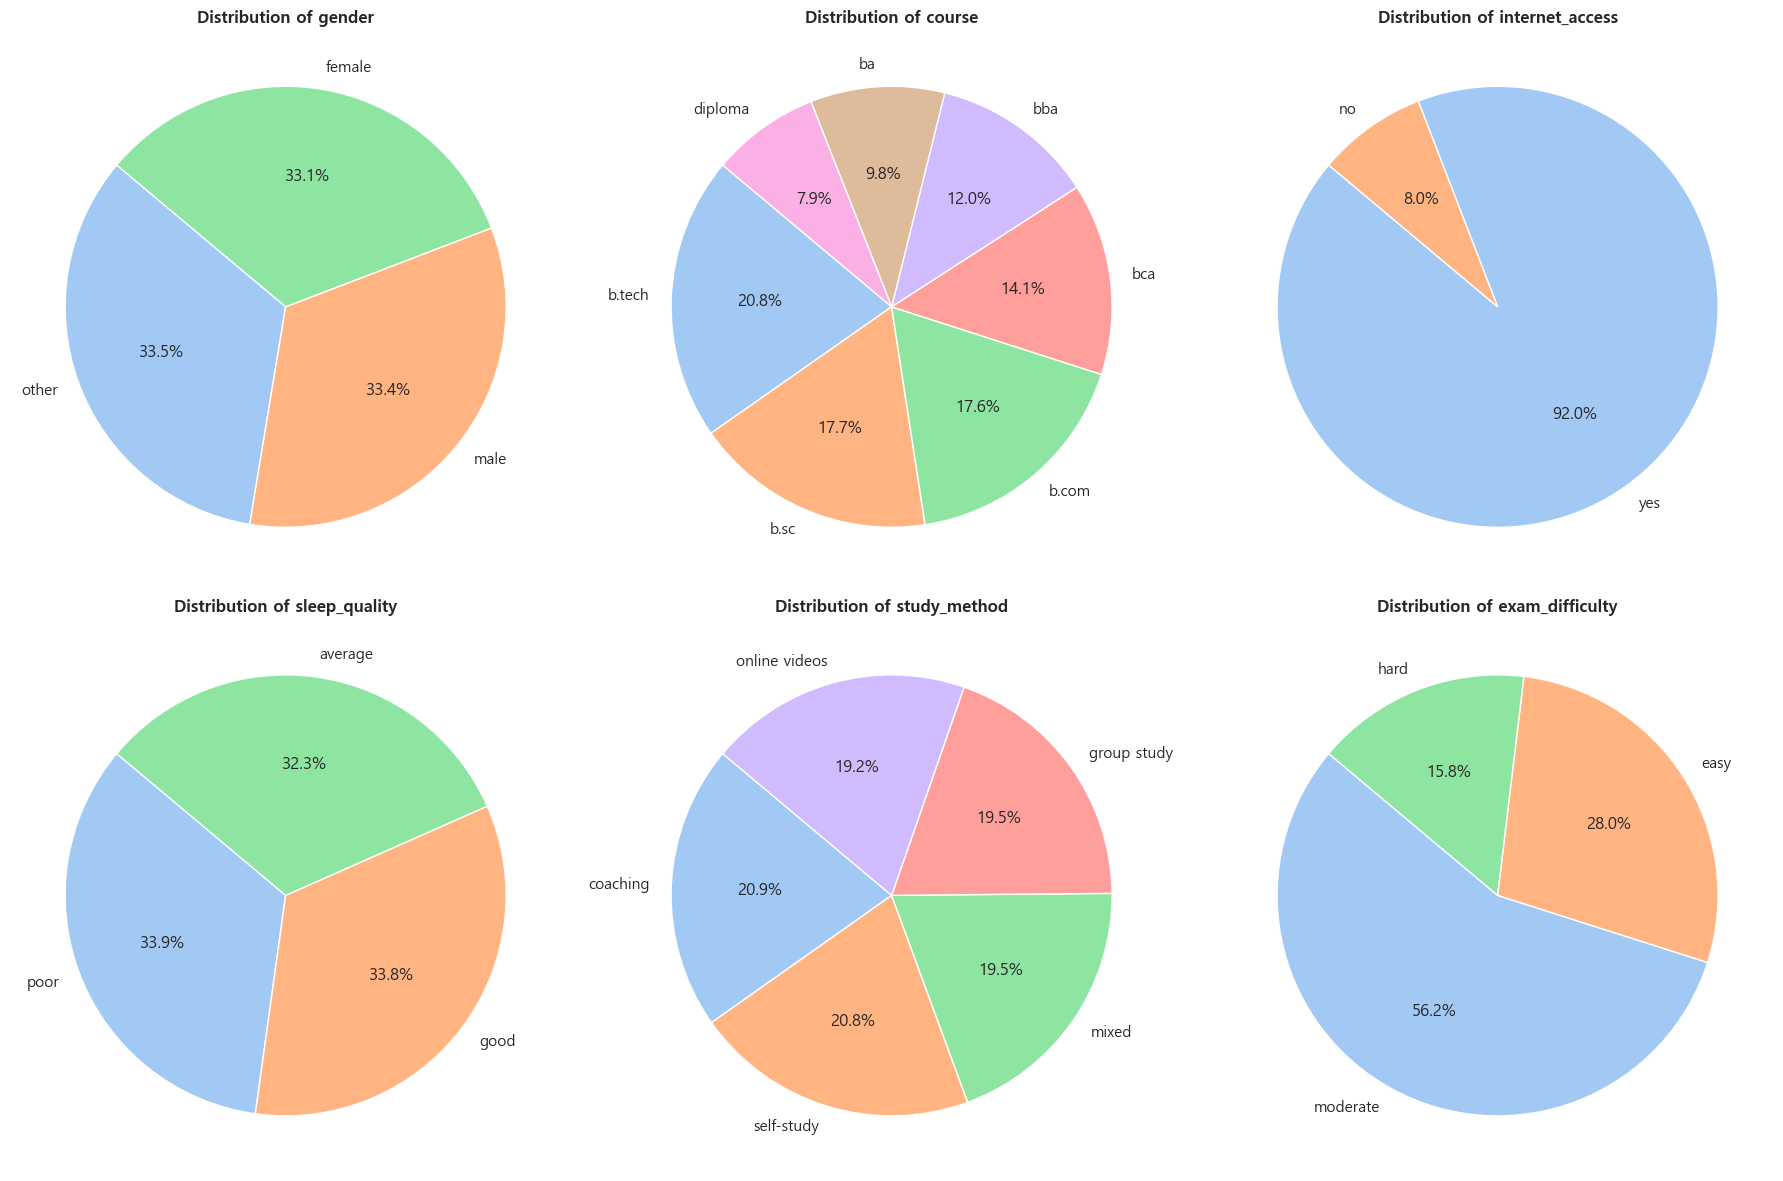

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화할 범주형 컬럼 리스트
cat_cols = ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'exam_difficulty']

# 서브플롯 설정 (2행 3열)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    # 데이터 계산 (비중 확인용)
    counts = train_df[col].value_counts()
    
    # 파이 차트 그리기
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, 
                colors=sns.color_palette('pastel'), wedgeprops={'edgecolor': 'w'})
    axes[i].set_title(f'Distribution of {col}', fontweight='bold')

plt.tight_layout()
plt.show()

C:\Users\subin\AppData\Local\Temp\ipykernel_19348\3441766865.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x='exam_difficulty', y='exam_score', data=train_df,
C:\Users\subin\AppData\Local\Temp\ipykernel_19348\3441766865.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='study_method', y='exam_score', data=train_df,
C:\Users\subin\AppData\Local\Temp\ipykernel_19348\3441766865.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[2], x='internet_access', y='exam_score', data=train_df,


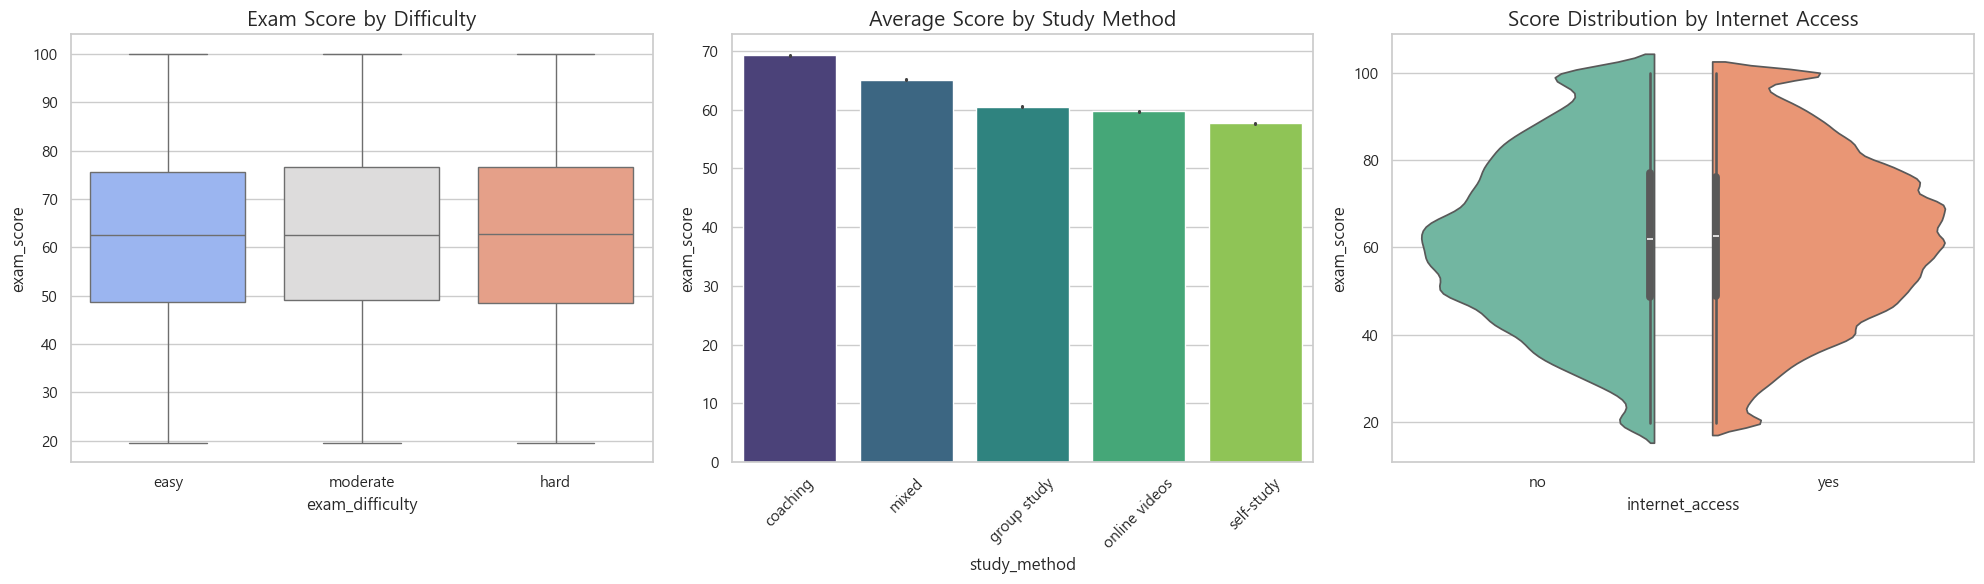

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한 화면에 3개의 그래프 출력
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# [1] 난이도 vs 점수 (Boxplot)
# 난이도 순서를 Easy -> Moderate -> Hard로 고정하여 경향성 파악
sns.boxplot(ax=axes[0], x='exam_difficulty', y='exam_score', data=train_df, 
            order=['easy', 'moderate', 'hard'], palette='coolwarm')
axes[0].set_title('Exam Score by Difficulty', fontsize=15)

# [2] 공부법 vs 점수 (Barplot)
# 평균 점수를 기준으로 정렬하여 어떤 방법이 가장 효과적인지 확인
method_order = train_df.groupby('study_method')['exam_score'].mean().sort_values(ascending=False).index
sns.barplot(ax=axes[1], x='study_method', y='exam_score', data=train_df, 
            order=method_order, palette='viridis')
axes[1].set_title('Average Score by Study Method', fontsize=15)
axes[1].tick_params(axis='x', rotation=45)

# [3] 인터넷 유무 vs 점수 (Violin Plot)
# 8%의 적은 데이터 분포를 더 세밀하게 보기 위해 바이올린 플롯 사용
sns.violinplot(ax=axes[2], x='internet_access', y='exam_score', data=train_df, 
               palette='Set2', split=True)
axes[2].set_title('Score Distribution by Internet Access', fontsize=15)

plt.tight_layout()
plt.show()

C:\Users\subin\AppData\Local\Temp\ipykernel_19348\2359273746.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x='study_method', y='study_hours', data=train_df,


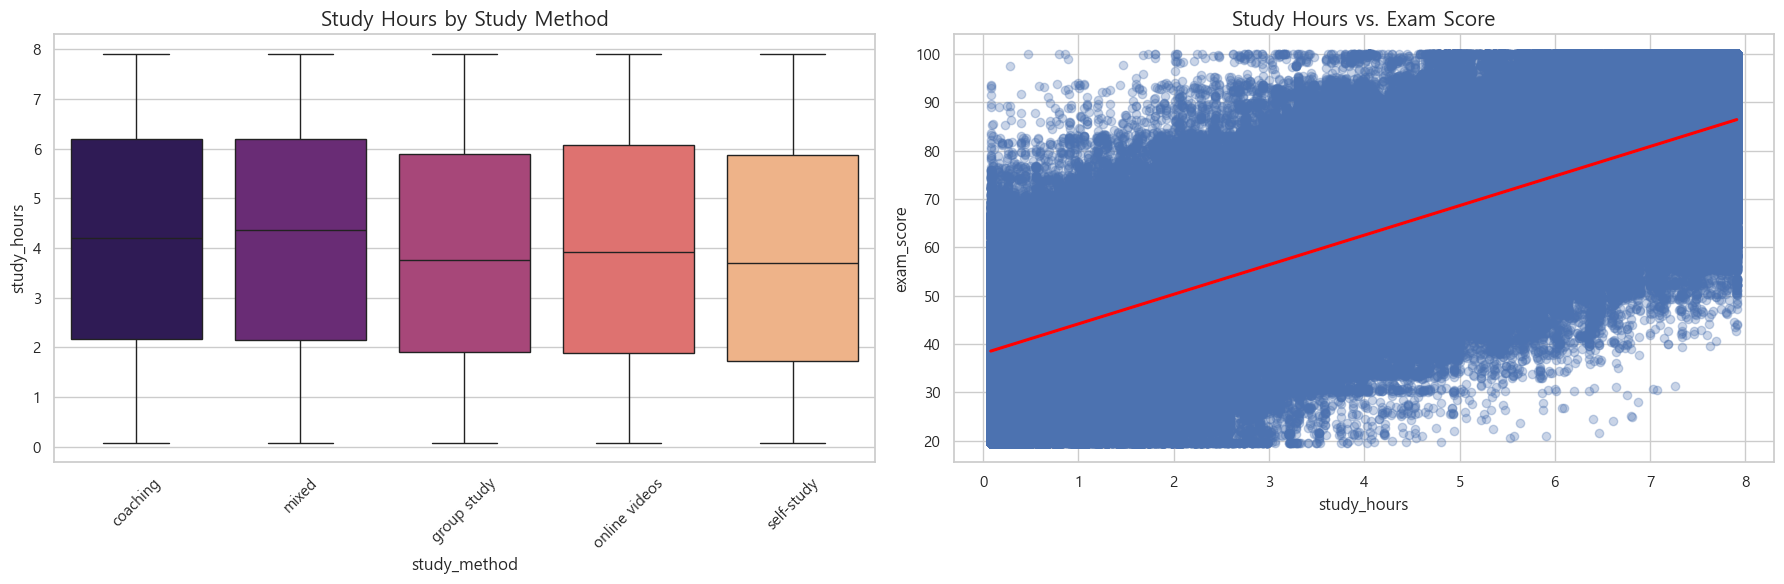

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한 화면에 두 개의 그래프 출력
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# [그래프 1] 공부 방법별 학습 시간 (Boxplot)
# 코칭 그룹이 실제로 잠을 줄여가며 더 많이 공부하는지 확인
sns.boxplot(ax=axes[0], x='study_method', y='study_hours', data=train_df, 
            palette='magma', order=method_order)
axes[0].set_title('Study Hours by Study Method', fontsize=15)
axes[0].tick_params(axis='x', rotation=45)

# [그래프 2] 공부 시간과 성적의 산점도 (Regression Plot)
# 공부 시간 자체가 성적에 미치는 절대적인 영향력 확인
sns.regplot(ax=axes[1], x='study_hours', y='exam_score', data=train_df, 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
axes[1].set_title('Study Hours vs. Exam Score', fontsize=15)

plt.tight_layout()
plt.show()

C:\Users\subin\AppData\Local\Temp\ipykernel_19348\298779090.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='study_method', y='study_hours', data=train_df, palette='Set2')


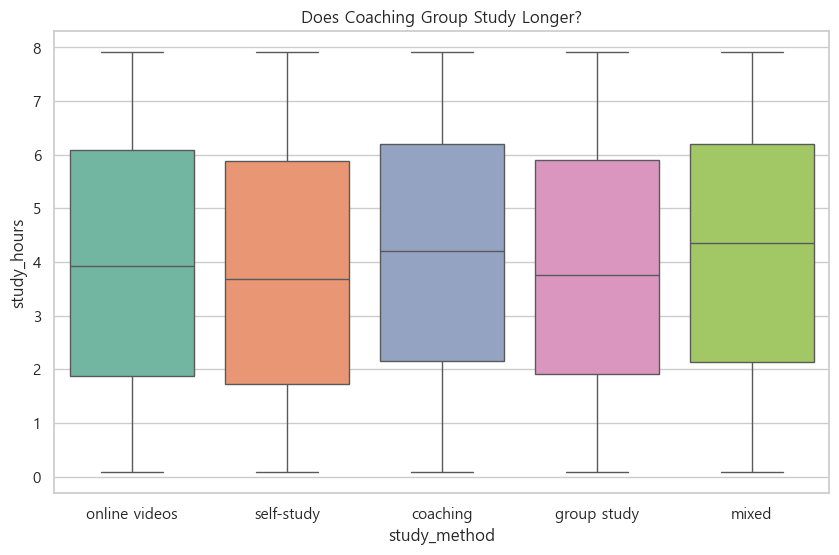

In [13]:
# 공부 방법별 학습 시간 분포 확인
plt.figure(figsize=(10, 6))
sns.boxplot(x='study_method', y='study_hours', data=train_df, palette='Set2')
plt.title('Does Coaching Group Study Longer?')
plt.show()

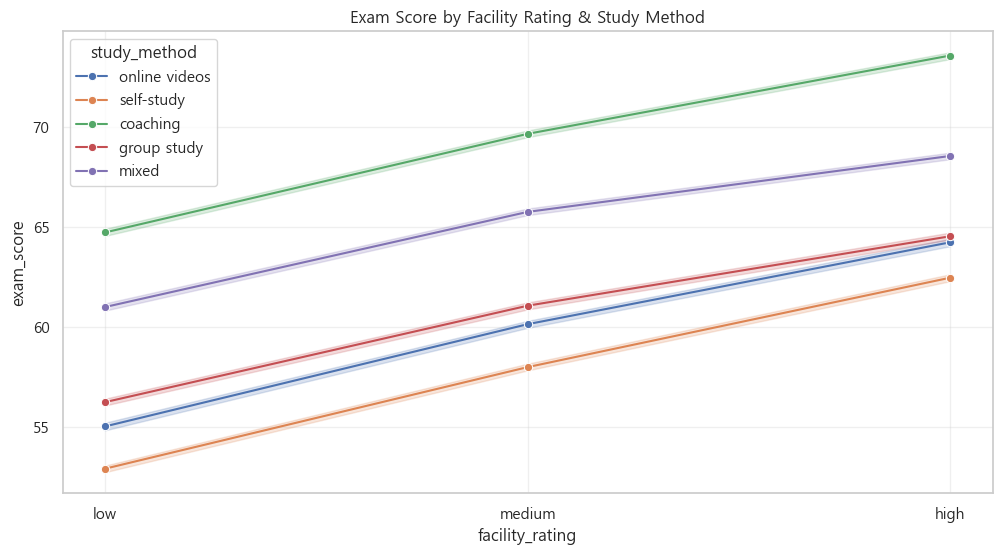

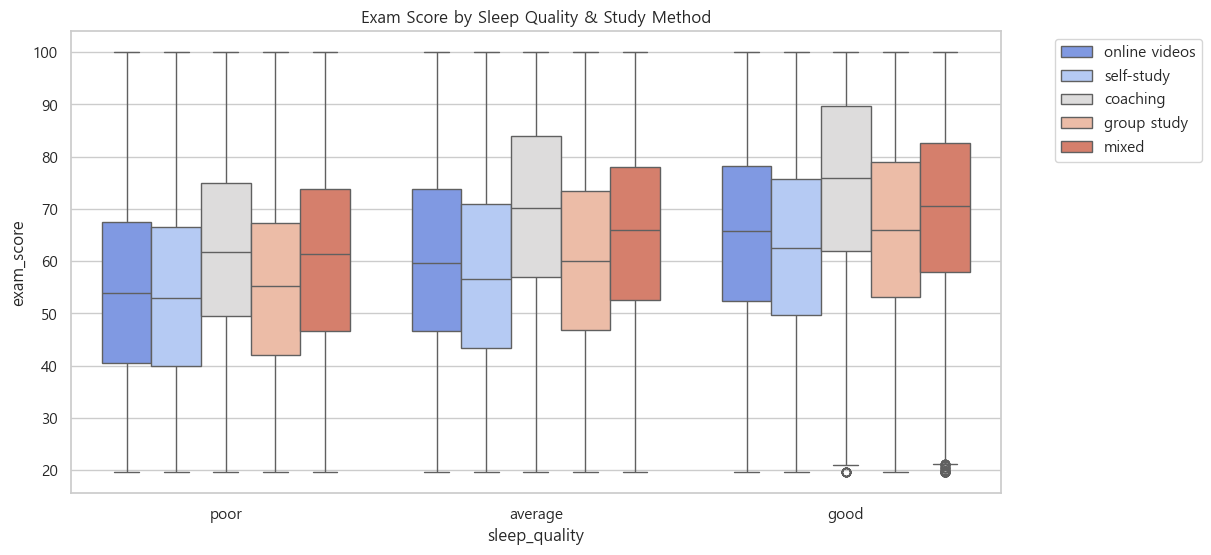

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 시설 만족도(facility_rating)와 공부 방법의 결합 분석
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_df, x='facility_rating', y='exam_score', hue='study_method', marker='o')
plt.title('Exam Score by Facility Rating & Study Method')
plt.grid(True, alpha=0.3)
plt.show()

# 2. 수면의 질(sleep_quality)에 따른 성적 분포 분석
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='sleep_quality', y='exam_score', hue='study_method', 
            order=['poor', 'average', 'good'], palette='coolwarm')
plt.title('Exam Score by Sleep Quality & Study Method')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

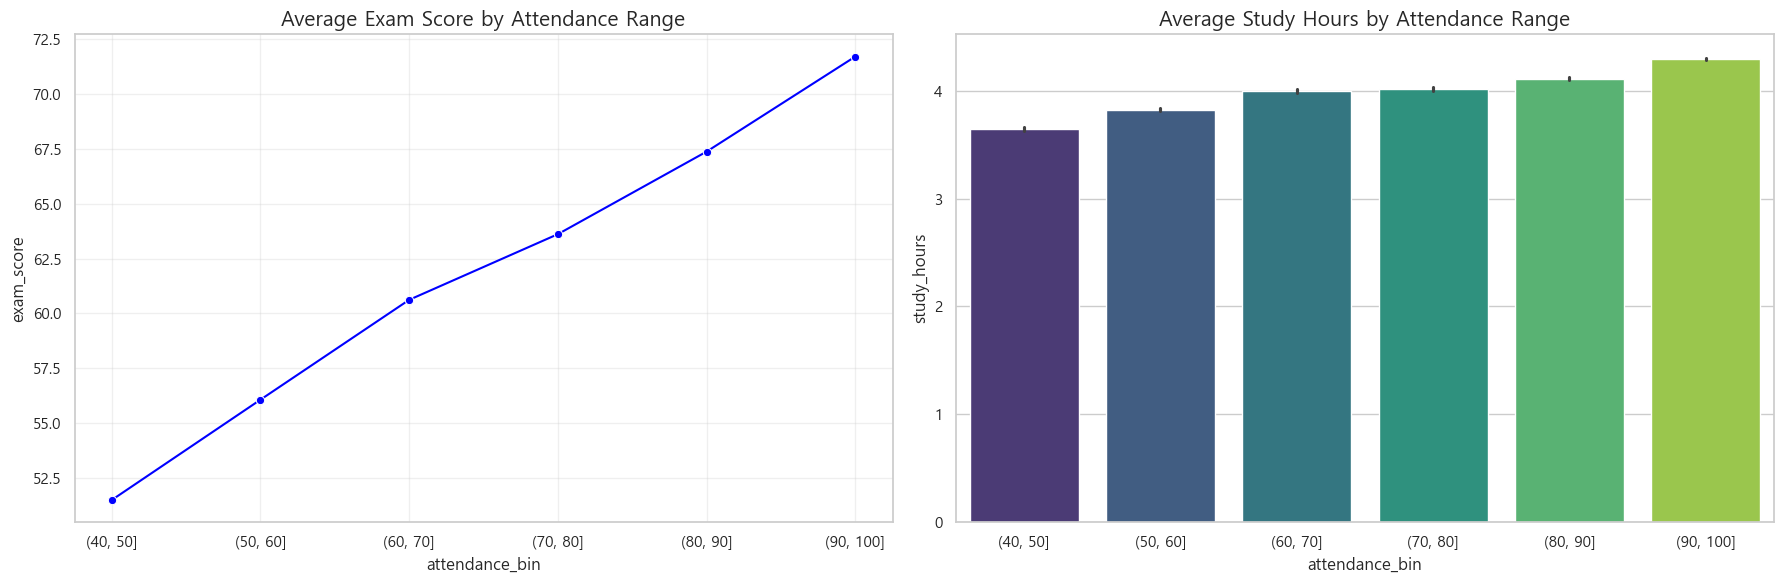

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 출석률 구간 나누기 및 '문자열' 변환 (오류 해결 포인트)
train_df['attendance_bin'] = pd.cut(train_df['class_attendance'], bins=range(40, 110, 10)).astype(str)

# 2. 시각화 설정
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# [그래프 1] 출석률 구간별 평균 성적 (꺾은선)
# 구간 순서가 꼬이지 않도록 데이터 정렬 후 시각화
sns.lineplot(ax=axes[0], data=train_df.sort_values('class_attendance'), 
             x='attendance_bin', y='exam_score', marker='o', color='blue', errorbar=None)
axes[0].set_title('Average Exam Score by Attendance Range', fontsize=15)
axes[0].grid(True, alpha=0.3)

# [그래프 2] 출석률 구간별 평균 공부 시간 (바 차트)
sns.barplot(ax=axes[1], data=train_df.sort_values('class_attendance'), 
            x='attendance_bin', y='study_hours', palette='viridis', hue='attendance_bin', legend=False)
axes[1].set_title('Average Study Hours by Attendance Range', fontsize=15)

plt.tight_layout()
plt.show()

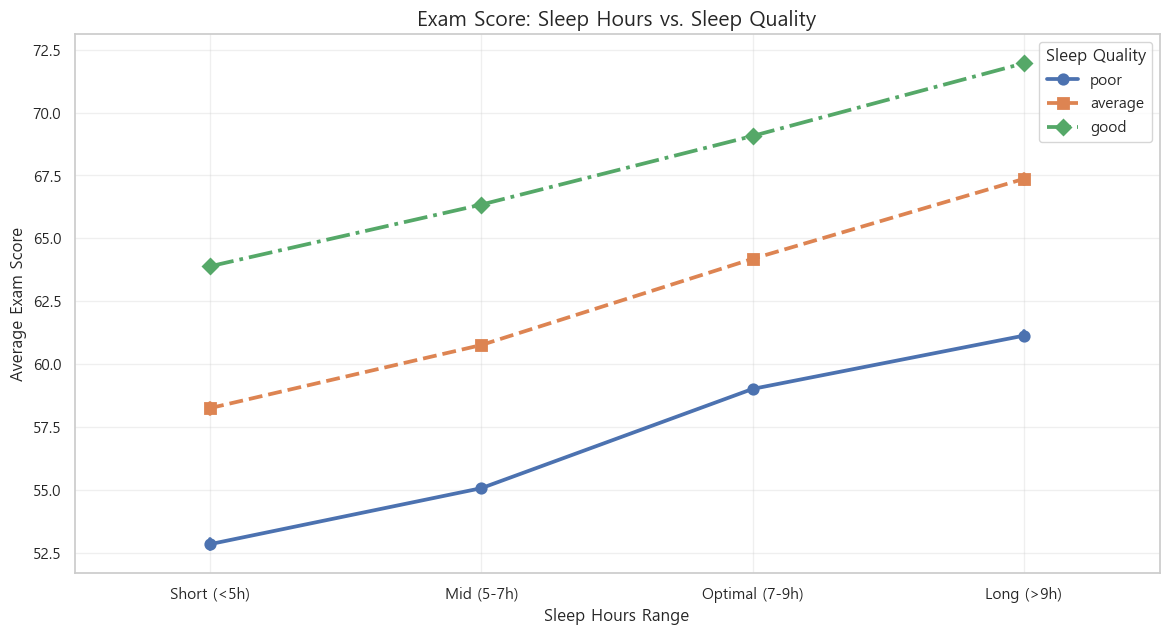

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 수면 시간을 2시간 단위 등으로 구간화 (예: 4-6, 6-8, 8-10)
train_df['sleep_range'] = pd.cut(train_df['sleep_hours'], bins=[0, 5, 7, 9, 12], 
                                 labels=['Short (<5h)', 'Mid (5-7h)', 'Optimal (7-9h)', 'Long (>9h)'])

# 2. 시각화: 수면 시간 구간별 + 수면 질에 따른 평균 성적
plt.figure(figsize=(14, 7))
sns.pointplot(data=train_df, x='sleep_range', y='exam_score', hue='sleep_quality', 
              hue_order=['poor', 'average', 'good'], markers=['o', 's', 'D'], linestyles=['-', '--', '-.'])

plt.title('Exam Score: Sleep Hours vs. Sleep Quality', fontsize=15)
plt.ylabel('Average Exam Score')
plt.xlabel('Sleep Hours Range')
plt.grid(True, alpha=0.3)
plt.legend(title='Sleep Quality')
plt.show()

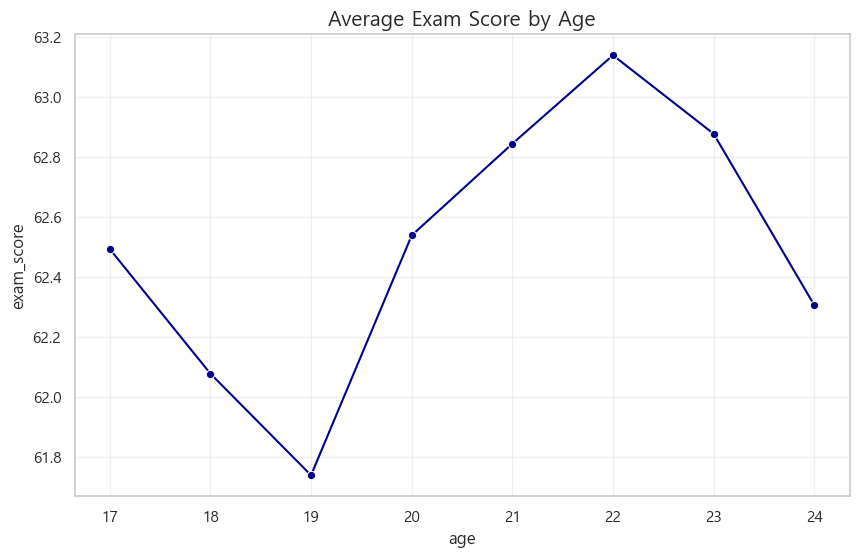

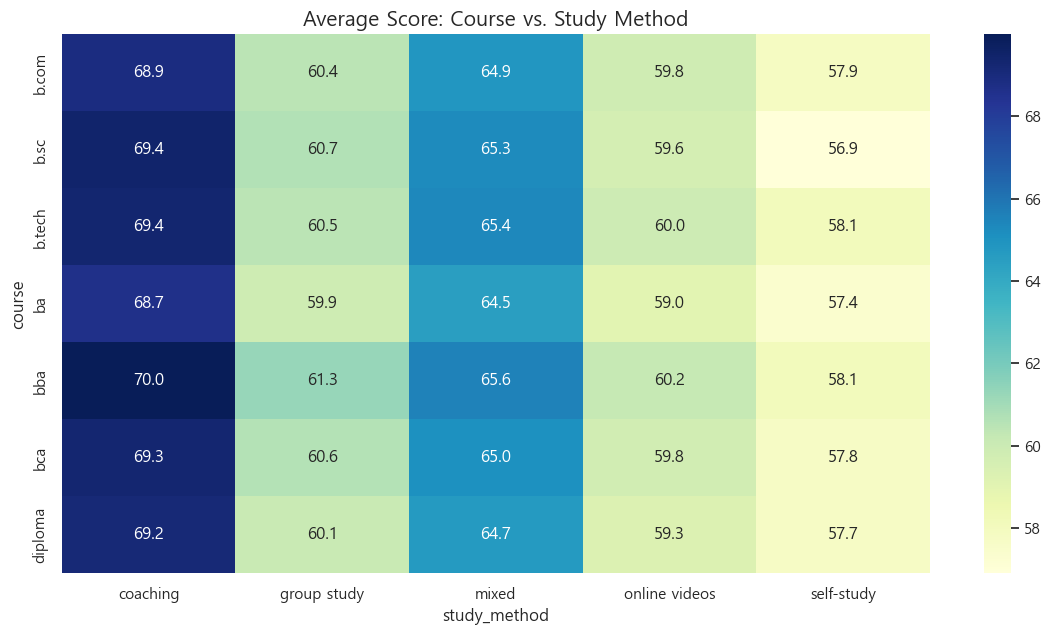

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 나이와 성적의 상관관계 (연령대별 평균 점수)
plt.figure(figsize=(10, 6))
age_score = train_df.groupby('age')['exam_score'].mean().reset_index()
sns.lineplot(data=age_score, x='age', y='exam_score', marker='o', color='darkblue')
plt.title('Average Exam Score by Age', fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()

# 2. 전공별 코칭 효과 분석 (전공 x 공부방법별 평균 점수)
plt.figure(figsize=(14, 7))
# 전공별로 코칭 유무에 따른 성적 차이를 보기 위해 피벗 테이블 생성
course_method_score = train_df.pivot_table(index='course', 
                                          columns='study_method', 
                                          values='exam_score', 
                                          aggfunc='mean')

# 시각화: 전공별로 공부 방법(특히 Coaching)이 미치는 영향
sns.heatmap(course_method_score, annot=True, cmap='YlGnBu', fmt=".1f")
plt.title('Average Score: Course vs. Study Method', fontsize=15)
plt.show()

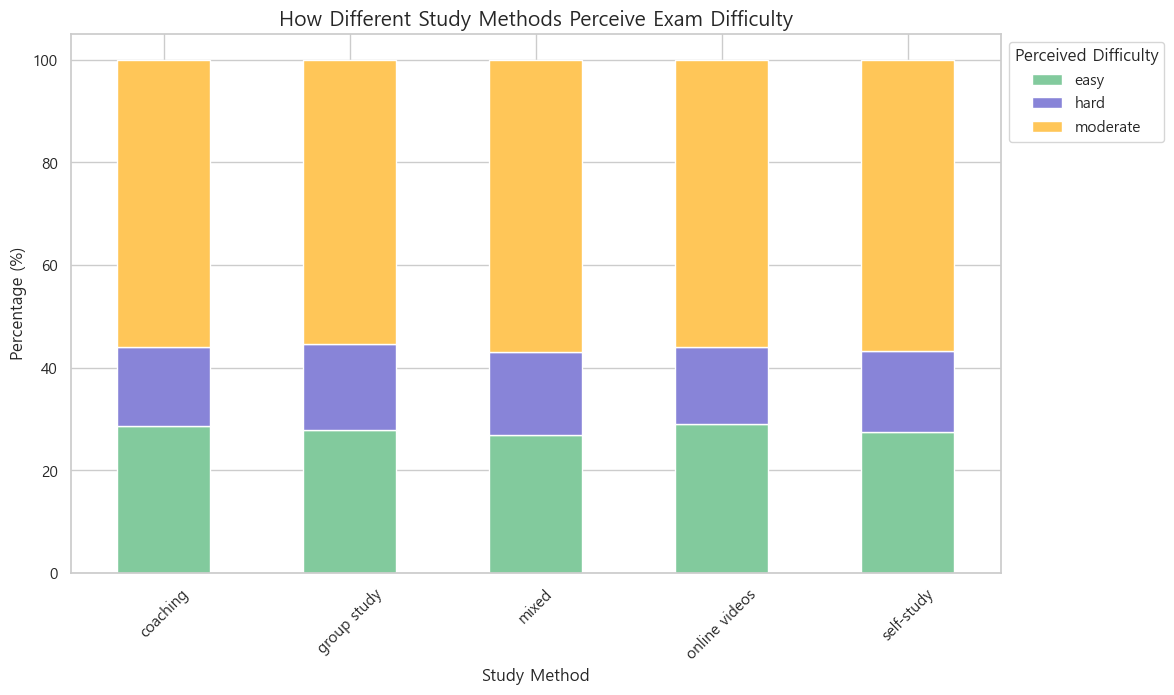

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 공부 방법별 체감 난이도 응답 비중 계산
method_difficulty = pd.crosstab(train_df['study_method'], train_df['exam_difficulty'], normalize='index') * 100

# 시각화 (Stacked Bar Chart)
method_difficulty.plot(kind='bar', stacked=True, figsize=(12, 7), color=['#82ca9d', '#8884d8', '#ffc658'])
plt.title('How Different Study Methods Perceive Exam Difficulty', fontsize=15)
plt.ylabel('Percentage (%)')
plt.xlabel('Study Method')
plt.legend(title='Perceived Difficulty', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.show()

In [19]:
# 공부 방법별 체감 난이도 교차표 생성 (행 방향 비율 계산)
difficulty_pct = pd.crosstab(train_df['study_method'], train_df['exam_difficulty'], normalize='index') * 100

# 보기 좋게 소수점 첫째 자리까지 반올림하여 출력
print("[ 공부 방법별 체감 난이도 비중 (%) ]")
print(difficulty_pct.round(1))

[ 공부 방법별 체감 난이도 비중 (%) ]
exam_difficulty  easy  hard  moderate
study_method                         
coaching         28.6  15.4      56.0
group study      28.0  16.6      55.4
mixed            26.9  16.2      56.8
online videos    29.0  15.1      55.9
self-study       27.6  15.7      56.8


[ 전공별 체감 난이도 비중 (%) ]
exam_difficulty  easy  hard  moderate
course                               
b.com            28.9  16.6      54.4
b.sc             28.2  15.5      56.3
b.tech           26.6  16.3      57.1
ba               28.6  15.2      56.2
bba              28.4  15.4      56.2
bca              27.7  15.0      57.3
diploma          28.5  16.0      55.5


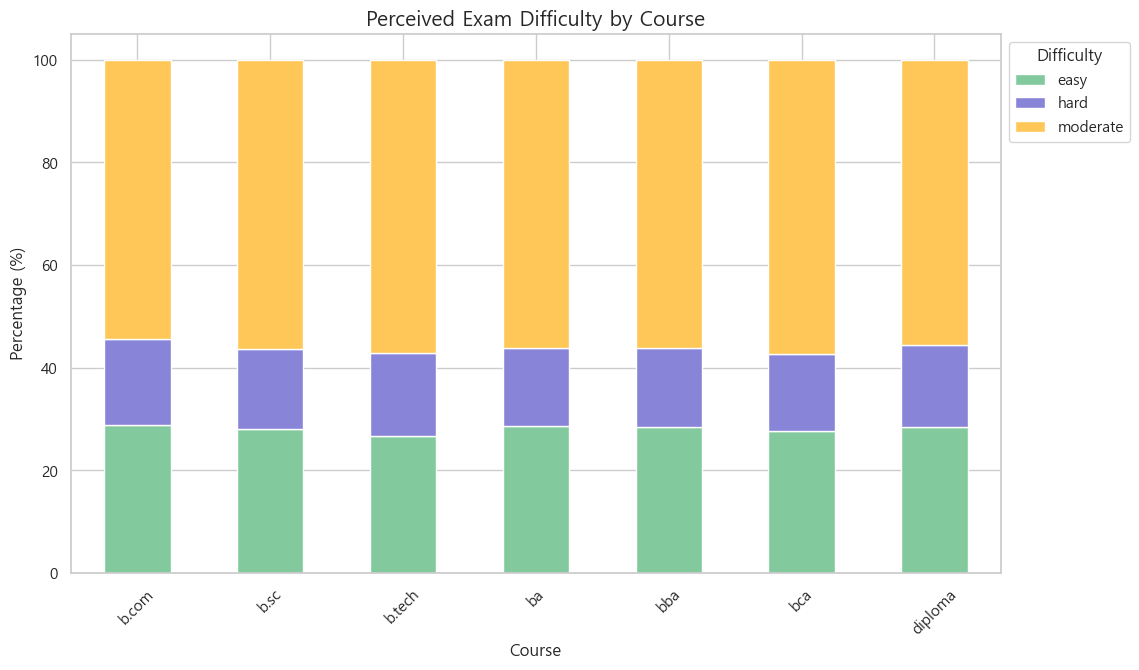

In [20]:
# 전공(Course)별 체감 난이도 교차표 생성 (행 방향 비율 계산)
course_difficulty_pct = pd.crosstab(train_df['course'], train_df['exam_difficulty'], normalize='index') * 100

# 결과 출력
print("[ 전공별 체감 난이도 비중 (%) ]")
print(course_difficulty_pct.round(1))

# 시각화 (Stacked Bar Chart로 시각적 균질성 확인)
course_difficulty_pct.plot(kind='bar', stacked=True, figsize=(12, 7), color=['#82ca9d', '#8884d8', '#ffc658'])
plt.title('Perceived Exam Difficulty by Course', fontsize=15)
plt.ylabel('Percentage (%)')
plt.xlabel('Course')
plt.legend(title='Difficulty', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x700 with 0 Axes>

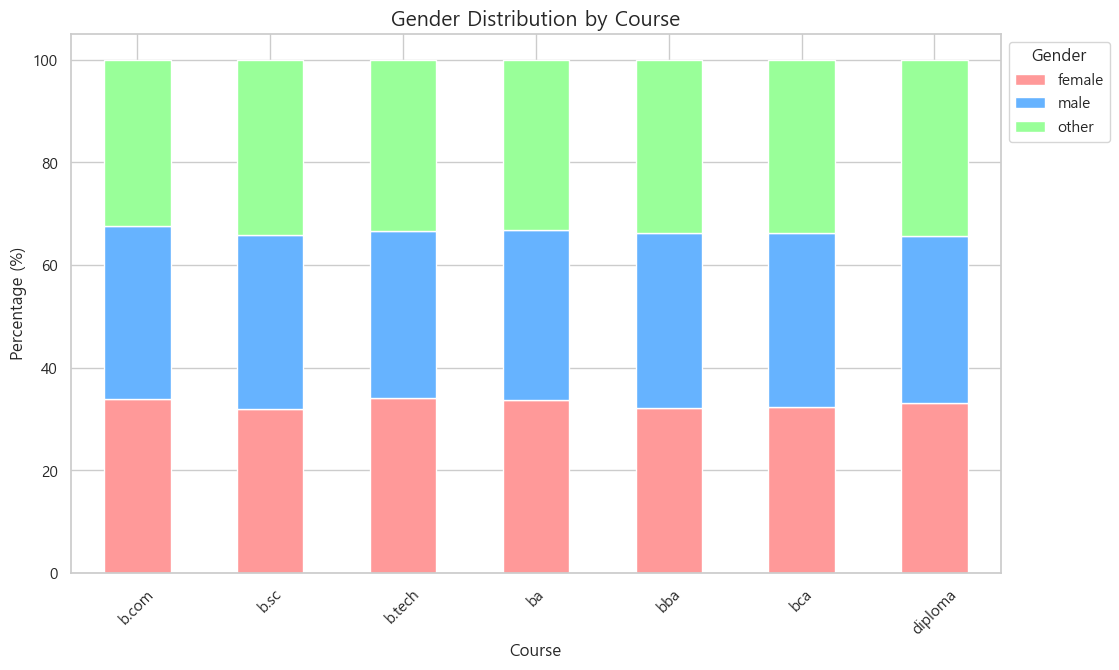

[ 전공별 성별 비중 (%) ]
gender   female  male  other
course                      
b.com      33.9  33.7   32.5
b.sc       31.9  33.9   34.2
b.tech     34.1  32.6   33.4
ba         33.7  33.2   33.1
bba        32.1  34.1   33.8
bca        32.4  33.8   33.8
diploma    33.1  32.6   34.3


In [21]:
# 전공(Course)별 성별(Gender) 분포 확인
plt.figure(figsize=(12, 7))
course_gender = pd.crosstab(train_df['course'], train_df['gender'], normalize='index') * 100

# 시각화 (Stacked Bar Chart)
course_gender.plot(kind='bar', stacked=True, figsize=(12, 7), color=['#ff9999','#66b3ff','#99ff99'])
plt.title('Gender Distribution by Course', fontsize=15)
plt.ylabel('Percentage (%)')
plt.xlabel('Course')
plt.legend(title='Gender', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.show()

# 수치 데이터 출력
print("[ 전공별 성별 비중 (%) ]")
print(course_gender.round(1))

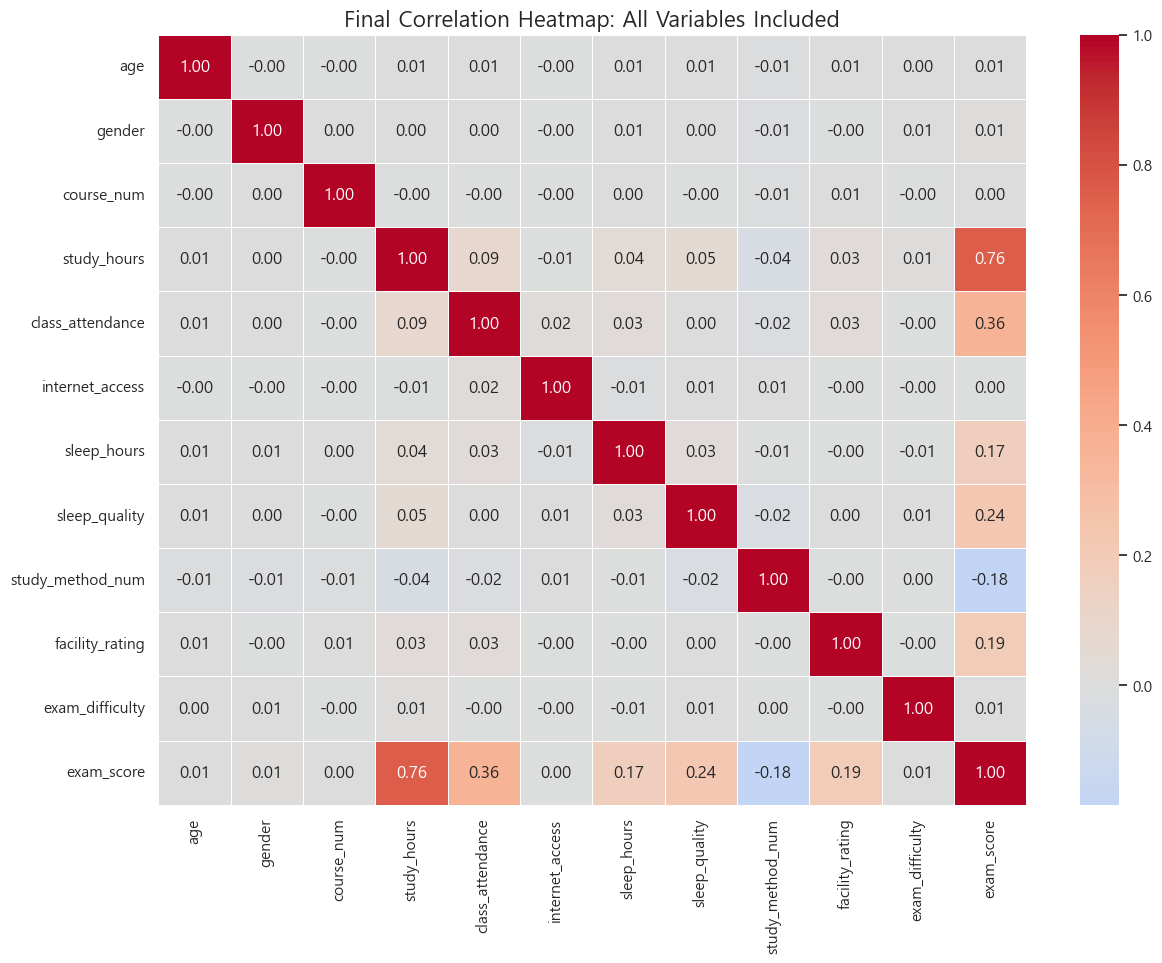

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 문자열(범주형) 데이터를 분석 가능한 수치로 변환
# 순서가 있는 데이터(Ordinal)는 등급에 맞게 매핑
mapping_dict = {
    'internet_access': {'no': 0, 'yes': 1},
    'sleep_quality': {'poor': 1, 'average': 2, 'good': 3},
    'facility_rating': {'low': 1, 'medium': 2, 'high': 3},
    'exam_difficulty': {'easy': 1, 'moderate': 2, 'hard': 3},
    'gender': {'male': 0, 'female': 1, 'other': 2}
}

df_encoded = train_df.copy()

# 매핑 적용
for col, mapping in mapping_dict.items():
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].map(mapping)

# 순서가 없는 데이터(Nominal)는 숫자로 인코딩
df_encoded['course_num'] = df_encoded['course'].astype('category').cat.codes
df_encoded['study_method_num'] = df_encoded['study_method'].astype('category').cat.codes

# 2. 상관계수 계산 (ID 제외 모든 수치 변수)
cols_to_corr = [
    'age', 'gender', 'course_num', 'study_hours', 'class_attendance', 
    'internet_access', 'sleep_hours', 'sleep_quality', 'study_method_num', 
    'facility_rating', 'exam_difficulty', 'exam_score'
]
corr_matrix = df_encoded[cols_to_corr].corr()

# 3. 히트맵 시각화
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Final Correlation Heatmap: All Variables Included', fontsize=16)
plt.show()

### 1. 성적 향상의 4대 핵심 동력

| 구분 | 데이터 기반 핵심 분석 결론 |
| --- | --- |
| **공부 방법** | **코칭(Coaching)** 은 전공 불문 가장 높은 효율을 보임 (독학 대비 약 **10~12점** 우위) |
| **환경 인프라** | **시설 만족도**는 성적과 정비례하며, 코칭과 결합할 때 학습 시너지가 극대화됨 |
| **신체적 요인** | **수면의 질**은 단순 공부 시간보다 집중력에 기여하며, 성적의 하한선을 결정함 |
| **심리적 요인** | 시험 난이도는 모두가 비슷하게 느끼므로, **"어렵게 느껴져도 포기하지 않는 관리력"** 이 관건 |

---

### 2. 📝 수면 섹션 상세 인사이트: "양(Amount)보다 질(Quality)"

* **양 vs 질 승부**: **수면의 질(Quality)** 이 수면 시간(양)보다 성적에 더 강력한 영향력을 미침
* **효율성 역설**: **짧은 숙면(Short + Good) > 긴 설잠(Long + Poor)** 수치가 증명하듯, 질 낮은 장시간 수면보다 고품질의 단기 수면이 성적 방어에 유리함
* **최적의 전략**: 최소 7시간 이상의 수면 시간을 확보하되, 숙면을 취할 수 있는 환경 조성이 성적 향상의 필수 조건임

---

### 3. 성실성 및 학습 태도 지표

* **출석률의 법칙**: 출석률은 성적과 뚜렷한 **양의 상관관계**를 가지며, 이는 성적을 견인하는 가장 기본적인 성실성 지표임
* **학습 병행 구조**: 출석률이 높은 학생일수록 자기주도 공부 시간도 함께 늘어나는 정석적인 학습 패턴을 보임

---

### 💡 최종 통합 결론 (Final Summary)

> **"성적은 공부 시간과 출석률에 정직하게 비례하지만, 동일 시간 대비 최고의 효율을 내는 핵심은 '코칭'에 있다. 이는 높은 '시설 만족도'와 '양질의 수면'이 보장된 환경에서 비로소 그 효과가 극대화된다."**



In [ ]:
# import pandas as pd
# import numpy as np
# from lightautoml.automl.presets.tabular_presets import TabularAutoML
# from lightautoml.tasks import Task
# from sklearn.metrics import mean_squared_error

# # 1. 태스크 설정: 회귀(Regression) 문제로 정의
# # loss와 metric을 'mse'로 설정하여 오차를 최소화하도록 유도합니다.
# task = Task('reg', loss='mse', metric='mse')

# # 2. 역할 설정 (Target과 ID 정의)
# roles = {
#     'target': 'exam_score',
#     'drop': ['id']
# }

# # 3. 모델 선언 및 학습
# # timeout: 학습 시간(초), 너무 짧으면 성능이 낮을 수 있으니 데이터 크기에 맞춰 조절하세요.
# automl = TabularAutoML(task=task, timeout=1800, cpu_limit=9)
# oof_predictions = automl.fit_predict(train_df, roles=roles, verbose=1)

# # 4. 검증 성능(MSE, RMSE) 계산
# actual_labels = train_df['exam_score'].values
# predicted_values = oof_predictions.data.flatten()

# # [핵심 수정] NaN이 아닌 인덱스만 추출하여 계산
# # LAMA가 시간 부족으로 예측하지 못한 행을 제외합니다.
# mask = ~np.isnan(predicted_values)

# if mask.any():
#     filtered_actual = actual_labels[mask]
#     filtered_predicted = predicted_values[mask]

#     mse_score = mean_squared_error(filtered_actual, filtered_predicted)
#     rmse_score = np.sqrt(mse_score)

#     print("\n" + "="*40)
#     print(f"✅ 모델 검증 완료 (유효 데이터 수: {mask.sum()}/{len(predicted_values)})")
#     print(f"📊 평균 제곱 오차 (MSE): {mse_score:.4f}")
#     print(f"📊 평균 제곱근 오차 (RMSE): {rmse_score:.4f}")
#     print(f"   (해석: 모델이 평균적으로 약 {rmse_score:.2f}점 정도의 오차를 보임)")
#     print("="*40 + "\n")
# else:
#     print("❌ 오류: 예측된 값이 없습니다. timeout 시간을 늘려주세요.")

'nlp' extra dependency package 'fasttext-numpy2' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


c:\Users\subin\miniconda3\envs\DS\Lib\site-packages\lightautoml\transformers\text.py:23: UserWarning: 'fasttext' - package isn't installed
  warnings.warn("'fasttext' - package isn't installed")


[09:38:59] Stdout logging level is INFO.
[09:38:59] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[09:38:59] Task: reg

[09:38:59] Start automl preset with listed constraints:
[09:38:59] - time: 1800.00 seconds
[09:38:59] - CPU: 9 cores
[09:38:59] - memory: 16 GB

[09:38:59] Train data shape: (630000, 15)

[09:39:24] Layer 1 train process start. Time left 1775.45 secs
[09:40:14] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[09:41:52] Time limit exceeded after calculating fold 1

[09:41:52] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -79.01260869847084
[09:41:52] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[09:41:52] Time left 1627.18 secs

[09:42:00] Selector_LightGBM fitting and predicting completed
[09:42:00] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[09:42:31] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -108.96664016771088
[09:42:31] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting compl

Optimization Progress:  26%|██▌       | 26/101 [04:15<12:16,  9.83s/it, best_trial=6, best_value=-109]

[09:46:46] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[09:46:46] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[09:47:58] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -108.84569235764751
[09:47:58] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[09:47:58] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[09:52:57] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -111.35357652511013
[09:52:57] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[09:52:57] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


Optimization Progress:   1%|          | 1/101 [00:53<1:29:43, 53.83s/it, best_trial=0, best_value=-111]

[09:53:51] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[09:53:51] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[10:03:58] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -111.4215616161824
[10:03:58] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[10:03:58] Time left 300.93 secs

[10:03:58] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[10:03:58] Layer 1 training completed.

[10:03:58] Blending: optimization starts with equal weights. Score = -104.9067288
[10:04:02] Blending: iteration 0: score = -79.0126087, weights = [1. 0. 0. 0. 0.]
[10:04:05] Blending: no improvements for score. Terminated.

[10:04:05] Blending: best score = -79.0126087, best weights = [1. 0. 0. 0. 0.]
[10:04:05] Automl preset training completed in 1505.97 seconds

[10:04:05] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) 


✅ 모델 검증 완료 (유효 데이터 수: 252000/630000)
📊 평균 제곱 오차 (MSE): 79.0126
📊 평균 제곱근 오차 (RMSE): 8.8889
   (해석: 모델이 평균적으로 약 8.89점 정도의 오차를 보임)



In [28]:
# [이전 셀에서 train_df 전처리가 완료된 상태여야 합니다]

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

# 1. 태스크 설정
task = Task('reg', loss='mse', metric='mse')

# 2. 역할 설정
roles = {'target': 'exam_score', 'drop': ['id']}

# 3. 모델 선언 (여기에 질문하신 코드를 넣습니다)
# 시간을 7200초로 늘리고, 알고리즘 4종 세트를 투입합니다.
automl = TabularAutoML(
    task=task, 
    timeout=7200, 
    cpu_limit=12, # CPU 성능을 최대한 활용
    general_params={'use_algos': [['linear_l2', 'lgb', 'cb', 'xgb']]}, 
    reader_params={'cv': 5, 'n_jobs': 12}
)

# 4. 학습 시작
# 이제 LAMA가 선형 모델과 트리 모델들을 섞어서 최적의 앙상블을 찾기 시작합니다.
oof_predictions = automl.fit_predict(train_df, roles=roles, verbose=1)

[10:30:26] Stdout logging level is INFO.
[10:30:26] Task: reg

[10:30:26] Start automl preset with listed constraints:
[10:30:26] - time: 7200.00 seconds
[10:30:26] - CPU: 12 cores
[10:30:26] - memory: 16 GB

[10:30:26] Train data shape: (630000, 15)

[10:30:49] Layer 1 train process start. Time left 7176.30 secs
[10:31:08] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[10:33:48] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -79.10749344336445
[10:33:48] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[10:33:48] Time left 6997.25 secs

[10:33:55] Selector_LightGBM fitting and predicting completed
[10:33:55] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[10:34:25] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -108.96664016771088
[10:34:25] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[10:34:25] Start fitting Lvl_0_Pipe_1_Mod_1_CatBoost ...
[10:37:22] Fitting Lvl_0_Pipe_1_Mod_1_CatBoost finished. score = -111.35357652511013
[10:37:22] Lvl_0_Pi

In [26]:
# 1. test_df에도 train_df와 동일한 파생 변수 생성
test_df['attendance_bin'] = pd.cut(test_df['class_attendance'], bins=range(40, 110, 10)).astype(str)
test_df['sleep_range'] = pd.cut(test_df['sleep_hours'], bins=[0, 4, 7, 10, 24], labels=['Very Short', 'Short', 'Good', 'Long']).astype(str)

# 2. (선택사항) 만약 LAMA가 NaN 오류를 냈던 것을 방지하려면 문자열 변환 다시 확인
for col in ['attendance_bin', 'sleep_range']:
    test_df[col] = test_df[col].fillna('Unknown')

# 3. 이제 다시 예측 실행
test_predictions = automl.predict(test_df)

# 4. 제출 파일 생성
submission = pd.DataFrame({
    'id': test_df['id'],
    'exam_score': test_predictions.data.flatten()
})
submission.to_csv('final_submission_linear.csv', index=False)

print("✅ test_df 컬럼 매칭 완료 및 파일 저장 성공!")

✅ test_df 컬럼 매칭 완료 및 파일 저장 성공!
